# PPO - Intuitive guide to state-of-the-art Reinforcement Learning

Proximal Policy Optimization (PPO) has been a state-of-the-art Reinforcement Learning (RL) algorithm since its proposal in the paper [Proximal Policy Optimization Algorithms (Schulman et. al., 2017)](https://arxiv.org/abs/1707.06347). This elegant algorithm can be and has been used for various tasks. Recently, it has also been used in the training of ChatGPT, the hottest machine-learning model at the moment.


PPO is not just widely used within the RL community, but it is also an excellent introduction to tackling RL through Deep Learning (DL) models.

In this notebook, I give a quick overview of the field of Reinforcement Learning, the taxonomy of algorithms to solve RL problems, and a review of the PPO algorithm proposed in the paper. Finally, I share my own implementation of the PPO algorithm in PyTorch, comment on the obtained results and finish with a conclusion.


**Check out the [GitHub Repository](https://github.com/BrianPulfer/PapersReimplementations/tree/master/ppo) to get .py files that you can use in other projects.**

# Author


<img src="https://www.brianpulfer.ch/static/media/avatar.54e9184eb33043f0169a.png" alt="Picture of Brian Pulfer" width="400"/> <br/>
**Brian Pulfer** <br/>
[🌐 Website](https://www.brianpulfer.ch) [🐦 Twitter](https://twitter.com/PulferBrian21), [🧑🏽‍💻 GitHub](https://github.com/BrianPulfer), [👔 LinekdIn](https://www.linkedin.com/in/BrianPulfer/)<br/>
University of Geneva <br/>
Stochastic Information Processing Group <br/>
<br/>
Last modified: <i>15.12.2022</i>

# Introduction

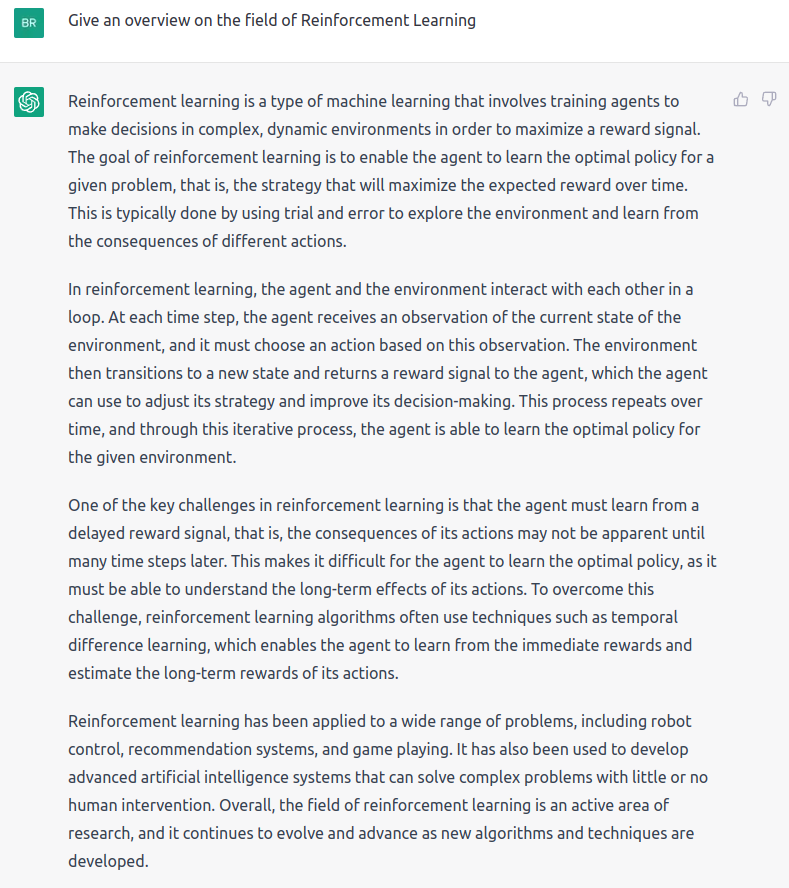

ChatGPT's answer to the prompt: "Give an overview on the field of Reinforcement Learning". While I asked help to ChatGPT for the introduction to the field of RL which was used to train ChatGPT itself (quite meta), I promise that everything in this article apart from this picture is written by me.

The classical picture that is first shown to people approaching RL is the following:

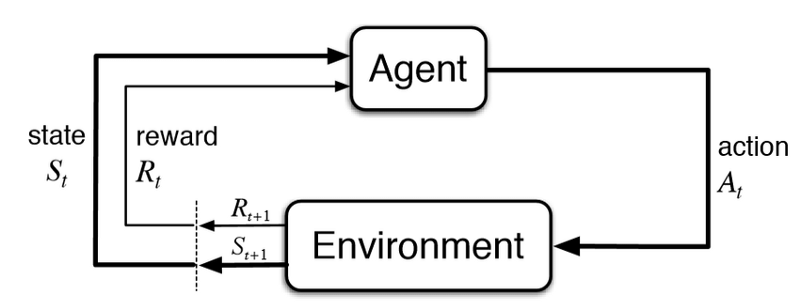

At each timestamp, the environment provides the agent with a reward and an observation of the current state. Given this information, the agent takes an action in the environment which responds with a new reward and state and so on. This very general framework can be applied in a variety of domains.
Our goal is to create an agent that can maximize the obtained rewards. In particular, we are typically interested in maximizing the sum of discounted rewards:

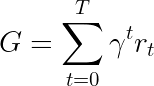

Where γ is a discount factor typically in the range [0.95, 0.99], and r_t is the reward for timestamp t.

# Algorithms

So how do we solve an RL problem? There are multiple algorithms, but they can be divided (for Markov Decision Processes or MDPs) into two categories: model-based (create a model of the environment) and model-free (just learn what to do given a state).

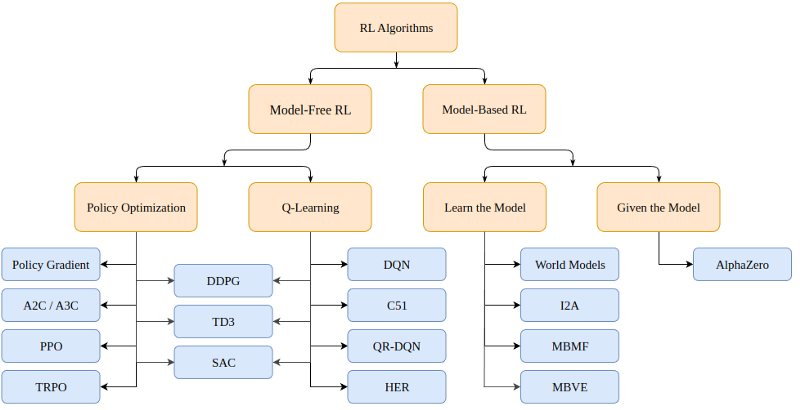

<b>Model-based</b> algorithms use a model of the environment and use this model to predict future states and rewards. The model is either given (e.g. a chessboard) or learned.

<b>Model-free</b> algorithms instead, directly learn how to act for the states encountered during training (Policy Optimization or PO), which state-action pairs yield good rewards (Q-Learning), or both at the same time.

<b>PPO</b> falls in the PO family of algorithms. We do not thus need a model of the environment to learn with the PPO algorithm. The main difference between PO and Q-Learning algorithms is that PO algorithms can be used in environments with continuous action space (i.e. where our actions have real values) and can find the optimal policy even if that policy is a stochastic one (i.e. acts probabilistically), whereas the Q-Learning algorithms cannot do either of those things. That's one more reason to prefer PO algorithms. On the other hand, Q-Learning algorithms tend to be simpler, more intuitive, and nicer to train.

# Policy Optimization (Gradient-Based)

PO algorithms try to learn a policy directly. To do so, they either use gradient-free (e.g. genetic algorithms) or, perhaps more commonly, gradient-based algorithms.

By gradient-based methods, we refer to all methods that try to estimate the gradient of the learned policy with respect to the cumulative rewards. If we know this gradient (or an approximation of it), we can simply move the parameters of the policy toward the direction of the gradient to maximize rewards.

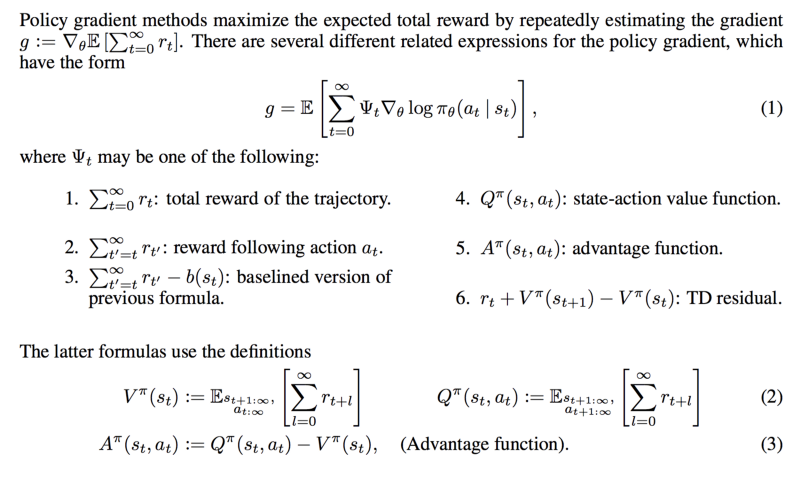

Notice that there are multiple ways to estimate the gradient. Here we find listed 6 different values that we could pick as our maximization objective: the total reward, the reward following one action, the reward minus a baseline version, the state-action value function, the advantage function (used in the original PPO paper) and the temporal difference (TD) residual. In principle, they all provide an estimate of the real gradient we are interested in.

# PPO

PPO is a (model-free) Policy Optimization Gradient-based algorithm. The algorithm aims to learn a policy that maximizes the obtained cumulative rewards given the experience during training.

It is composed of an <b>actor $π_θ(. | s_t)$</b> which outputs a probability distribution for the next action given the state at timestamp t, and by a <b>critic $V(s_t)$</b> which estimates the expected cumulative reward from that state (a scalar). Since both actor and critic take the state as an input, a backbone architecture can be shared between the two networks which extract high-level features.

PPO aims at making the policy more likely to select actions that have a high "advantage", that is, that have a much higher measured cumulative reward than what the critic could predict. At the same time, we do not wish to update the policy too much in a single step, as it will probably incur in optimization problems. Finally, we would like to provide a bonus for the policy if it has high entropy, as to motivate exploration over exploitation. 
The total loss function (to be maximized) is composed of three terms: a $L^{CLIP}$ term, a Value Function ($L^{VF}$) term, and an entropy bonus $S$.

The final objective is the following:

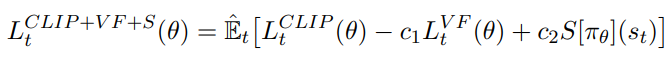

Where $c_1$ and $c_2$ are hyper-parameters that weigh the importance of the accuracy of the critic and exploration capabilities of the policy respectively.



## $L^{CLIP}$ Term

The loss function motivates, as we said, the maximization of the probability of actions that resulted in an advantage (or minimization of the probability if the actions resulted in a negative advantage):

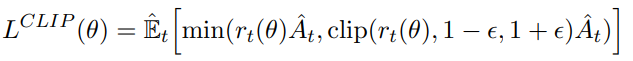

Where:

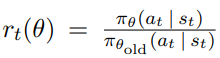

Is a ratio that measures how likely we are to do that previous action now (with an updated policy) with respect to before. In principle, we do not wish this coefficient to be too high, as it means that the policy changed abruptly. That's why we take the minimum of it and the clipped version between [1-ϵ, 1+ϵ], where ϵ is a hyper-parameter.

The advantage is computed as:

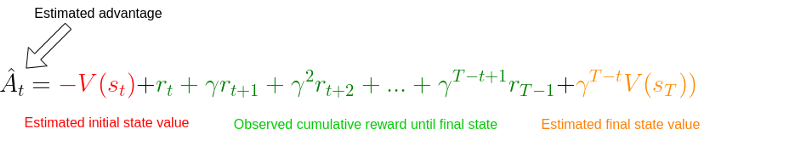

We see that it simply measures how wrong the critic was for the given state $s_t$. If we obtained a higher cumulative reward, the advantage estimate will be positive and we will make the action we took in this state more likely. Vice-versa, if we expected a higher reward and we got a smaller one, the advantage estimate will be negative and we will make the action taken in this step less likely.

Notice that if we go all the way down to a state $s_T$ that was terminal, we do not need to rely on the critic itself and we can simply compare the critic with the actual cumulative reward. In that case, the estimate of the advantage is the true advantage. This is what we are going to do in our implementation of the cart-pole problem.


## $L^{VF}$ Term

To have a good estimate of the advantage, however, we need a critic that can predict the value of a given state. This model is learned in a supervised fashion with a simple MSE loss:

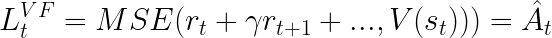

At each iteration, we update the critic too such that it will give us more and more accurate values for states as training progresses.

## $S$ (entropy) term

Finally, we encourage exploration with a small bonus on the entropy of the output distribution of the policy. We consider the standard entropy:

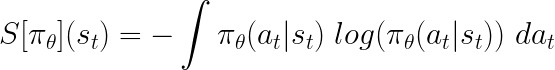



# Implementation

Don't worry if the theory still seems a bit shady. The implementation will hopefully make everything clear.

In [1]:
!pip install gym==0.26.2 wandb pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## PPO-Independent code

In [2]:
from argparse import ArgumentParser

import gym
import numpy as np
import wandb

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR
from torch.distributions.categorical import Categorical

import pytorch_lightning as pl

In [3]:
# Log in to your W&B account (if you don't have a weight and biases account, I suggest making one, it's free!)
# If you have a google account linked to W&B, this line will automatically do the login.
wandb.login()

wandb: Currently logged in as: peutlefaire. Use `wandb login --relogin` to force relogin


True

### Hyper-parameters

The important hyper-parameters of PPO are the number of actors, horizon, epsilon, the number of epochs for each optimization phase, the learning rate, the discount factor gamma, and the constants that weigh the different loss terms c1 and c2.

In [4]:
max_iterations = 100
n_actors = 8
horizon = 128
epsilon = 0.1
n_epochs = 3
batch_size = 32 * 8
lr = 2.5 * 1e-4
gamma = 0.99
c1 = 1
c2 = 0.01
n_test_episodes = 5
seed = 0

Notice that, by default, the parameters are set as described in the paper. Ideally, our code should run on GPU if possible, so we create a simple utility function.

In [5]:
def get_device():
    """Gets the device (GPU if any) and logs the type"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Found GPU device: {torch.cuda.get_device_name(device)}")
    else:
        device = torch.device("cpu")
        print("No GPU found: Running on CPU")
    return device

When we apply RL, we typically have a buffer that stores states, actions, and rewards encountered by the current model. These are used to update our models. We create a utility function run_timestamps that will run a given model on a given environment for a fixed number of timestamps (re-setting the environment if the episode finishes). We also use an option `render=False` in case we just want to see how the trained model does.

In [13]:
@torch.no_grad()
def run_timestamps(env, model, timestamps=128, render=False, device="cpu"):
    """Runs the given policy on the given environment for the given amount of timestamps.
     Returns a buffer with state action transitions and rewards."""
    buffer = []
    state = env.reset()[0]

    # Running timestamps and collecting state, actions, rewards and terminations
    for ts in range(timestamps):
        # Taking a step into the environment
        model_input = torch.from_numpy(state).unsqueeze(0).to(device).float()
        action, action_logits, value = model(model_input)
        new_state, reward, terminated, truncated, info = env.step(action.item())

        # Rendering / storing (s, a, r, t) in the buffer
        if render:
            env.render()
        else:
            buffer.append([model_input, action, action_logits, value, reward, terminated or truncated])

        # Updating current state
        state = new_state

        # Resetting environment if episode terminated or truncated
        if terminated or truncated:
            state = env.reset()[0]

    return buffer

The output of the function (when not rendering) is a buffer containing states, taken actions, action probabilities (logits), estimated critic's values, rewards, and the termination state for the provided policy for each timestamp. Notice that the function uses the decorator `@torch.no_grad()`, so we will not need to store gradients for the actions taken during the interactions with the environment.

## Code for PPO

Now that we got the trivial stuff out of the way, is time to implement the core algorithm.

Ideally, we would like our main function to look something like this:



```
def main():
    # Parsing program arguments
    args = parse_args()
    print(args)

    # Setting seed
    pl.seed_everything(args["seed"])

    # Getting device
    device = get_device()

    # Creating environment (discrete action space)
    env_name = "CartPole-v1"
    env = gym.make(env_name)

    # Creating the model, training it and rendering the result
    # (We are missing this part 😅)
    model = MyPPO(env.observation_space.shape, env.action_space.n).to(device)
    training_loop(env, model, args)
    model = load_best_model()
    testing_loop(env, model)
```

We already got most of it. We just need to define the PPO model, the training, and the test functions.

The architecture of the PPO model is not the interesting part here. We just need two models (actor and critic) that will act in the environment. Of course, the model architecture plays a crucial role in harder tasks, but with the cart pole, we can be confident that some MLP will do the job.
Thus, we can create a `MyPPO` class that contains actor and critic models. 

Optionally, we may decide that part of the architecture between the two is shared. When running the forward method for some states, we return the sampled actions by the actor, the relative probabilities for each possible action (logits), and the critic's estimated values for each state.

In [7]:
class MyPPO(nn.Module):
    """Implementation of a PPO model. The same backbone is used to get actor and critic values."""

    def __init__(self, in_shape, n_actions, hidden_d=100, share_backbone=False):
        # Super constructor
        super(MyPPO, self).__init__()

        # Attributes
        self.in_shape = in_shape
        self.n_actions = n_actions
        self.hidden_d = hidden_d
        self.share_backbone = share_backbone

        # Shared backbone for policy and value functions
        in_dim = np.prod(in_shape)

        def to_features():
            return nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_dim, hidden_d),
                nn.ReLU(),
                nn.Linear(hidden_d, hidden_d),
                nn.ReLU()
            )

        self.backbone = to_features() if self.share_backbone else nn.Identity()

        # State action function
        self.actor = nn.Sequential(
            nn.Identity() if self.share_backbone else to_features(),
            nn.Linear(hidden_d, hidden_d),
            nn.ReLU(),
            nn.Linear(hidden_d, n_actions),
            nn.Softmax(dim=-1)
        )

        # Value function
        self.critic = nn.Sequential(
            nn.Identity() if self.share_backbone else to_features(),
            nn.Linear(hidden_d, hidden_d),
            nn.ReLU(),
            nn.Linear(hidden_d, 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        action = self.actor(features)
        value = self.critic(features)
        return Categorical(action).sample(), action, value

Notice that `Categorical(action).sample()` creates a categorical distribution with the action logits and samples from it one action (for each state).

Finally, we can take care of the actual algorithm in the `training_loop` function. As we know from the paper, the actual signature of the function should look something like this:



```
def training_loop(env, model, max_iterations, n_actors, horizon, gamma, 
epsilon, n_epochs, batch_size, lr, c1, c2, device, env_name=""):
  # TODO...
```

Here's the pseudo-code provided in the paper for the PPO training procedure:

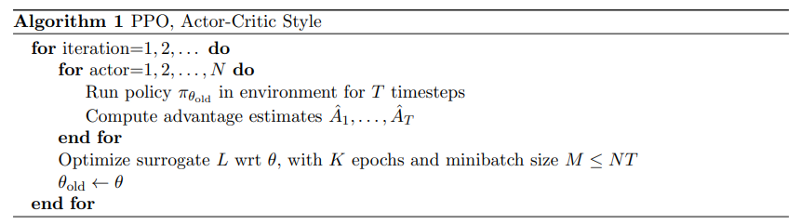

The pseudo-code for PPO is relatively simple: we simply collect interactions with the environment by multiple copies of our policy model (called actors) and use the objective previously defined to optimize both actor and critic networks.

Since we need to measure the cumulative rewards that we really obtained, we create a function that, given a buffer, replaces rewards at each timestamp with the cumulative rewards:

In [8]:
def compute_cumulative_rewards(buffer, gamma):
    """Given a buffer with states, policy action logits, rewards and terminations,
    computes the cumulative rewards for each timestamp and substitutes them into the buffer."""
    curr_rew = 0.

    # Traversing the buffer on the reverse direction
    for i in range(len(buffer) - 1, -1, -1):
        r, t = buffer[i][-2], buffer[i][-1]

        if t:
            curr_rew = 0
        else:
            curr_rew = r + gamma * curr_rew

        buffer[i][-2] = curr_rew

    # Getting the average reward before normalizing (for logging and checkpointing)
    avg_rew = np.mean([buffer[i][-2] for i in range(len(buffer))])

    # Normalizing cumulative rewards
    mean = np.mean([buffer[i][-2] for i in range(len(buffer))])
    std = np.std([buffer[i][-2] for i in range(len(buffer))]) + 1e-6
    for i in range(len(buffer)):
        buffer[i][-2] = (buffer[i][-2] - mean) / std

    return avg_rew

Notice that, in the end, we normalize the cumulative rewards. This is a standard trick to make the optimization problem easier and the training smoother.

Now that we can obtain a buffer with states, actions taken, actions probabilities, and cumulative rewards, we can write a function that, given a buffer, computes the three loss terms for our final objective:

In [9]:
def get_losses(model, batch, epsilon, annealing, device="cpu"):
    """Returns the three loss terms for a given model and a given batch and additional parameters"""
    # Getting old data
    n = len(batch)
    states = torch.cat([batch[i][0] for i in range(n)])
    actions = torch.cat([batch[i][1] for i in range(n)]).view(n, 1)
    logits = torch.cat([batch[i][2] for i in range(n)])
    values = torch.cat([batch[i][3] for i in range(n)])
    cumulative_rewards = torch.tensor([batch[i][-2] for i in range(n)]).view(-1, 1).float().to(device)

    # Computing predictions with the new model
    _, new_logits, new_values = model(states)

    # Loss on the state-action-function / actor (L_CLIP)
    advantages = cumulative_rewards - values
    margin = epsilon * annealing
    ratios = new_logits.gather(1, actions) / logits.gather(1, actions)

    l_clip = torch.mean(
        torch.min(
            torch.cat(
                (ratios * advantages,
                 torch.clip(ratios, 1 - margin, 1 + margin) * advantages),
                dim=1),
            dim=1
        ).values
    )

    # Loss on the value-function / critic (L_VF)
    l_vf = torch.mean((cumulative_rewards - new_values) ** 2)

    # Bonus for entropy of the actor
    entropy_bonus = torch.mean(torch.sum(-new_logits * (torch.log(new_logits + 1e-5)), dim=1))

    return l_clip, l_vf, entropy_bonus

Notice that, in practice, we use an `annealing` parameter that is set to 1 and linearly decayed towards 0 throughout the training. The idea is that as training progresses, we want our policy to change less and less. Also notice that the `advantages` variable is a simple difference between tensors for which we are not tracking gradients, unlike `new_logits` and `new_values`.

Now that we have a way to interact with the environment and store buffers, compute the (true) cumulative rewards and obtain the loss terms, we can write the final training loop:

In [10]:
MODEL_PATH = "model.pt"

def training_loop(env, model, max_iterations, n_actors, horizon, gamma, epsilon, n_epochs, batch_size, lr,
                  c1, c2, device, env_name=""):
    """Train the model on the given environment using multiple actors acting up to n timestamps."""

    # Starting a new Weights & Biases run
    wandb.init(project="Papers Re-implementations",
               entity="peutlefaire",
               name=f"PPO - {env_name} (Google Colab)",
               config={
                   "env": str(env),
                   "number of actors": n_actors,
                   "horizon": horizon,
                   "gamma": gamma,
                   "epsilon": epsilon,
                   "epochs": n_epochs,
                   "batch size": batch_size,
                   "learning rate": lr,
                   "c1": c1,
                   "c2": c2
               })

    # Training variables
    max_reward = float("-inf")
    optimizer = Adam(model.parameters(), lr=lr, maximize=True)
    scheduler = LinearLR(optimizer, 1, 0, max_iterations * n_epochs)
    anneals = np.linspace(1, 0, max_iterations)

    # Training loop
    for iteration in range(max_iterations):
        buffer = []
        annealing = anneals[iteration]

        # Collecting timestamps for all actors with the current policy
        for actor in range(1, n_actors + 1):
            buffer.extend(run_timestamps(env, model, horizon, False, device))

        # Computing cumulative rewards and shuffling the buffer
        avg_rew = compute_cumulative_rewards(buffer, gamma)
        np.random.shuffle(buffer)

        # Running optimization for a few epochs
        for epoch in range(n_epochs):
            for batch_idx in range(len(buffer) // batch_size):
                # Getting batch for this buffer
                start = batch_size * batch_idx
                end = start + batch_size if start + batch_size < len(buffer) else -1
                batch = buffer[start:end]

                # Zero-ing optimizers gradients
                optimizer.zero_grad()

                # Getting the losses
                l_clip, l_vf, entropy_bonus = get_losses(model, batch, epsilon, annealing, device)

                # Computing total loss and back-propagating it
                loss = l_clip - c1 * l_vf + c2 * entropy_bonus
                loss.backward()

                # Optimizing
                optimizer.step()
            scheduler.step()

        # Logging information to stdout
        curr_loss = loss.item()
        log = f"Iteration {iteration + 1} / {max_iterations}: " \
              f"Average Reward: {avg_rew:.2f}\t" \
              f"Loss: {curr_loss:.3f} " \
              f"(L_CLIP: {l_clip.item():.1f} | L_VF: {l_vf.item():.1f} | L_bonus: {entropy_bonus.item():.1f})"
        if avg_rew > max_reward:
            torch.save(model.state_dict(), MODEL_PATH)
            max_reward = avg_rew
            log += " --> Stored model with highest average reward"
        print(log)

        # Logging information to W&B
        wandb.log({
            "loss (total)": curr_loss,
            "loss (clip)": l_clip.item(),
            "loss (vf)": l_vf.item(),
            "loss (entropy bonus)": entropy_bonus.item(),
            "average reward": avg_rew
        })

    # Finishing W&B session
    wandb.finish()

Finally, to see how the final model does, we use the following `testing_loop` function:

In [11]:
def testing_loop(env, model, n_episodes, device):
    """Runs the learned policy on the environment for n episodes"""
    for _ in range(n_episodes):
        run_timestamps(env, model, timestamps=128, render=True, device=device)

And our main program is simply:

In [14]:
# Setting seed
pl.seed_everything(seed)

# Getting device
device = get_device()

# Creating environment (discrete action space)
env_name = "CartPole-v1"
env = gym.make(env_name)

# Creating the model (both actor and critic)
model = MyPPO(env.observation_space.shape, env.action_space.n).to(device)

# Training
training_loop(env, model, max_iterations, n_actors, horizon, gamma, epsilon, n_epochs, batch_size, lr, c1, c2, device, env_name)

# Loading best model
model = MyPPO(env.observation_space.shape, env.action_space.n).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# Testing (won't render on google colab)
# env = gym.make(env_name, render_mode="human")
# testing_loop(env, model, n_test_episodes, device)

# Closing environment
env.close()


INFO:lightning_lite.utilities.seed:Global seed set to 0


Found GPU device: Tesla T4


average reward,▁
loss (clip),▁
loss (entropy bonus),▁
loss (total),▁
loss (vf),▁
average reward,14.09199
loss (clip),0.03831
loss (entropy bonus),0.69062
loss (total),-0.74887
loss (vf),0.79408


Iteration 1 / 100: Average Reward: 13.67	Loss: -1.016 (L_CLIP: -0.1 | L_VF: 1.0 | L_bonus: 0.7) --> Stored model with highest average reward
Iteration 2 / 100: Average Reward: 11.86	Loss: -0.952 (L_CLIP: 0.0 | L_VF: 1.0 | L_bonus: 0.7)
Iteration 3 / 100: Average Reward: 16.51	Loss: -0.826 (L_CLIP: 0.2 | L_VF: 1.0 | L_bonus: 0.7) --> Stored model with highest average reward
Iteration 4 / 100: Average Reward: 17.02	Loss: -0.762 (L_CLIP: 0.0 | L_VF: 0.8 | L_bonus: 0.7) --> Stored model with highest average reward
Iteration 5 / 100: Average Reward: 23.73	Loss: -0.941 (L_CLIP: -0.0 | L_VF: 0.9 | L_bonus: 0.7) --> Stored model with highest average reward
Iteration 6 / 100: Average Reward: 20.82	Loss: -0.877 (L_CLIP: 0.0 | L_VF: 0.9 | L_bonus: 0.7)
Iteration 7 / 100: Average Reward: 25.04	Loss: -0.825 (L_CLIP: -0.1 | L_VF: 0.7 | L_bonus: 0.6) --> Stored model with highest average reward
Iteration 8 / 100: Average Reward: 22.93	Loss: -0.815 (L_CLIP: 0.0 | L_VF: 0.8 | L_bonus: 0.6)
Iteration 9 

average reward,▁▁▂▂▃▄▃▄▇▆▇▇███▇▇▇▇▇█▇███████▇█████▇▇█▇▇
loss (clip),▃▇▄▄▄▆▃█▄▂▃▇▃▅▄▃▆▁▆▄▄▄▅▄▄▃▄▆▃▄▄▄▄▅▄▄▆▅▃▆
loss (entropy bonus),██▆▅▄▄▄▃▃▃▃▂▂▂▁▂▂▃▂▂▂▁▂▁▂▂▂▁▃▁▂▂▂▂▂▂▃▃▂▂
loss (total),▃▄▄▄▅▇▅▇▅▃▄▆▂▃▅▅▅▂▆▇▃▄▃▄▂▁▄▅▄▂▂▂▄▃▄▄█▄▃▅
loss (vf),▆▇▅▅▄▃▃▄▄▅▄▅▇▆▄▃▅▆▄▂▇▅▇▆▇█▅▅▄▇█▇▅▇▆▅▁▅▅▅
average reward,80.77855
loss (clip),0.10809
loss (entropy bonus),0.55965
loss (total),-0.7274
loss (vf),0.84109


# Results

The Weights & Biases logs allow us to visualize the logged metrics and losses. In particular, we have access to plots of the loss and its terms and the average reward per iteration.

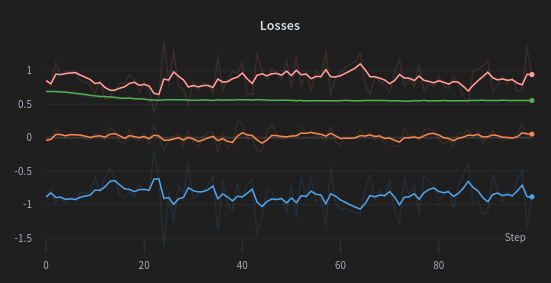

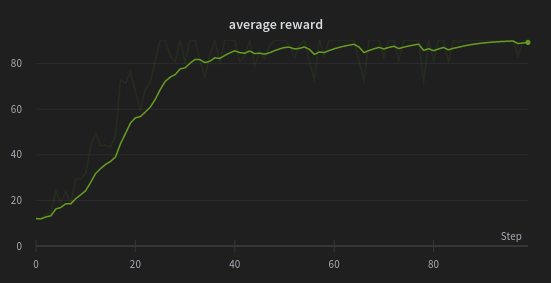

As the cart pole environment is not extremely challenging, our algorithm quickly finds a solution to the problem, maximizing the average reward after just ~20 steps. Also, since the environment only has 2 possible actions, the entropy term remains basically fixed.

Finally, here's what we get if we render the final policy in action!

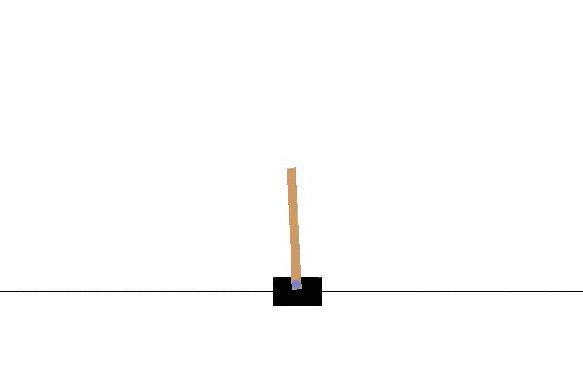



# Conclusion

PPO is a state-of-the-art RL policy optimization (thus model-free) algorithm and as such, it can be virtually used in any environment. Also, PPO has a relatively simple objective function and relatively few hyper-parameters to be tuned.

You can find my personal re-implementation of the PPO algorithm under the GitHub repository. Feel free to play around with it or adapt it to your own project!

If you enjoyed this story, let me know! Feel free to reach out for further discussions. Wish you happy hacking with PPO✌️

# Go-deeper links

Schulman et. al. 's [original paper](https://arxiv.org/abs/1707.06347)

OpenAI's ["Spinning Up guide to Deep RL"](https://spinningup.openai.com/en/latest/index.html)

Lilian Weng's ["A (Long) Peek into Reinforcement Learning"](https://lilianweng.github.io/posts/2018-02-19-rl-overview/)

Lilian Weng's ["Policy Gradient Algorithms"](https://lilianweng.github.io/posts/2018-04-08-policy-gradient/)